# Giant Diffusion in Tilted Periodic Potentials

## Introduction

Consider the overdamped motion of particle in the one dimensional  periodic potential after the influence of a constant force, described by the following Langevien equation:

$$ \dot x = f(x) + \sqrt{2D}\xi(t),$$

where:

 - $f(x) = -U'(x)$ and the potential is $U(x) = \sin(x) - F x$
 - $xi(t)$ - white Gaussian noise with mean zero and $<\xi(t)\xi(s)>=\delta(t-s)$ correlation function
 - $D$ is the thermal diffusion of $D=kT/\gamma$ (in this case we have $\gamma=1$)

We want to obtain an effective coarse grained coefficient

$$D_{eff} =  \lim_{t\to\infty} \frac{\langle (x(t) - m(t))^2 \rangle}{t}$$

where:

 - $m(t) = \langle x(t) \rangle$
 - averaging is over the realization of the system (trajectories)
 
This system shows the phenomenons of $D_{eff}$ growth in the $D\to0$ boundary

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.010602

## Problems

1. Implement the Euler-Maruyama scheme [link](https://el.us.edu.pl/ekonofizyka/index.php/MKZR:Stochastyczne_r%C3%B3wnania_r%C3%B3%C5%BCniczkowe) for the above stochastic equation for CUDA.

2. Implement a scheme based on finite differences and explicit integration in time solving the Fokker-Planck equation for CUDA.

3. Recreate, for example, Figure 1 from [PhysRevLett.87.010602] (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.010602) for each method.

In [0]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sympy
import time 

In [2]:
!pip install --upgrade sympy
!pip install pycuda

     |████████████████████████████████| 5.3MB 50.0MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


     |████████████████████████████████| 1.6MB 52.8MB/s 
     |████████████████████████████████| 61kB 30.6MB/s 
     |████████████████████████████████| 471kB 50.0MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4534407 sha256=838b74dc2a717f8b7791066ffcc8396f8bf94d9c1cdd65c5eaef3792cd151df2
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2019.1.1-py2.py3-none-any.whl size=58424 sha256=c7ba098c58b43217efba3e1e5d1dc12b02ad0c532cc11f197bd69a21227e9607
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Created wheel for mako: filename=Mako-1.1.0-cp36-none-any.whl size=75363 sha256=12d3214c784a66210f4ba546b6e24e542769807a144b560c511b68fc5db82382
  Stored in directory: /root/.cache/pip/wheels/98/32/7b/a291926643fc1d1e02593e0d9e247c5a866a366b8343b7aa27
Successfully built pycuda pytools mako


In [0]:
from sympy.codegen.ast import real, float32, float64
from sympy.codegen.ast import Declaration, Variable, Pointer

var = lambda x,p:sympy.ccode(Declaration(Variable(sympy.Symbol(x), type=p)) )
pvar = lambda x,p:sympy.ccode(Declaration(Pointer(sympy.Symbol(x), type=p)) )

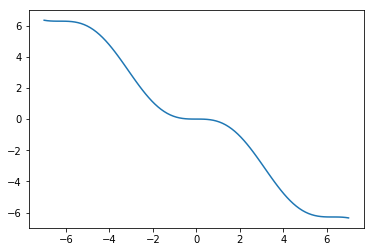

1.0F - cosf(x) float  float * 


In [4]:
precision = float32

if precision == float64:
    np_prec = np.float64

if precision == float32:
    np_prec = np.float32


def make_U_f(precision=float32):
    x = sympy.Symbol('x')
    U = sympy.sin(x) - 1.*x

    f = -sympy.diff(U, x, 1) 
    
    U_lamb = sympy.lambdify([x, ], U, 'numpy')
    f_lamb = sympy.lambdify([x, ], f, 'numpy')
    
    f_code = sympy.ccode(f,type_aliases={real: precision})


    
    return U_lamb,f_lamb,f_code,var("",precision),pvar("",precision)

U, f, f_code,fp,pfp = make_U_f(precision=precision)
x = np.linspace(-7,7,100)
plt.figure()
plt.plot(x,U(x))
plt.show()
print(f_code,fp,pfp)

In [5]:
print(f_code,fp,pfp)

1.0F - cosf(x) float  float * 


In [6]:
print(f([1,2,3]))

[0.45969769 1.41614684 1.9899925 ]


## Langevin equation

In [0]:
N = 12800
nsteps = 50000
dt = 0.005
Dyf = 0.01
a = np.sqrt(2*Dyf*dt)
x = np.zeros(N)

In [8]:
cpu_t = time.time()
for i in range(nsteps):
    x += f(x)*dt + a*np.random.randn(N)
cpu_t = time.time() - cpu_t

print( cpu_t, (N*nsteps)/cpu_t/1000**2," M iterations/sek" )
dt_mc = dt

41.19976472854614 15.534069289394807  M iterations/sek


## Fokker-Planck equation

In [9]:
import time
import numpy as np

x1,x2 = -2*np.pi,30*np.pi

s = int((x2-x1)/(2*np.pi))
N = s*250  # space discretization
h = (x2-x1)/(N-1) 
 
total_t = nsteps*dt # from prev. sim!

Nsteps = 1000*int(total_t)

X = np.linspace(x1, x2, N+1)[:-1]
t = np.linspace(0,total_t,Nsteps)
dt = t[1] - t[0]

print( "N =",N,"dt =",dt,'Nsteps =',Nsteps)

F = f(X)
u = np.zeros(N)
i0 = np.where(np.isclose(X,0))[0][0]
u[i0:i0+1] = 1.0/h
every = 100
Tlst = []

tm = time.time()
for i in range(Nsteps):
    At = 1.0
    if i%every == 0:
        Tlst.append(u.copy())
 
    u[1:-1] = u[1:-1] + dt*( -np.gradient(F*u)[1:-1]/h + Dyf/h**2*np.diff(u,2))

    #u[0] =  u[0] + dt*(-At*(F[1]*u[1]-F[-1]*u[-1])/(2*h) + Dyf/h**2*(u[-1]+u[1]-2.0*u[0]) )
    #u[-1] =  u[-1] + dt*(-At*(F[0]*u[0]-F[-2]*u[-2])/(2*h) + Dyf/h**2*(u[-2]+u[0]-2.0*u[-1]) )

tm = time.time()-tm
print ("Saved ",len(Tlst), " from ", Nsteps, "h= ",h)

print( tm,"s")

N = 4000 dt = 0.001000004000016 Nsteps = 250000
Saved  2500  from  250000 h=  0.02513902598521465
11.779420137405396 s


Now we can compute histograms of particle positions:

In [10]:
hist_cpu,xs = np.histogram(x, np.linspace(0,100,1300), normed=True)
xs = (xs[1:]+xs[:-1])/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


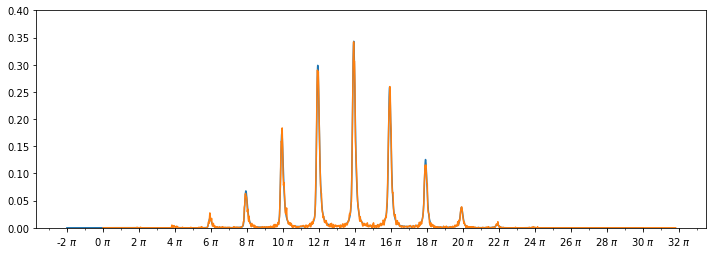

In [11]:
plt.figure(figsize=(12,4))

plt.plot(X,u)
plt.plot(xs,hist_cpu)
plt.ylim(0,.4)

ax = plt.gca()
fig = plt.gcf()
import matplotlib.ticker as tck
ax.xaxis.set_minor_locator(tck.MultipleLocator(base=np.pi))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=2*np.pi))
ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x,pos: '%g $\pi$'%(x/(np.pi))))
plt.show()

### Results:

Averages calculated from the $P(x)$ (`u`) distribution:

In [12]:
print ('t=',dt*Nsteps,"v =", np.sum(X*u)*h/(dt*Nsteps), "  Deff =",(h*np.sum((X-np.sum(X*u)*h)**2*u))/(2*dt*Nsteps) )

t= 250.00100000400002 v = 0.17097442883440386   Deff = 0.18405249503901214


Means after particles from the simulation of Langenvin equation:

In [13]:
print('t=',nsteps*dt_mc,"v =", np.mean(x)/(nsteps*dt_mc), "  Deff =",np.var(x)/(2*nsteps*dt_mc))

t= 250.0 v = 0.17063092500166982   Deff = 0.18389516114666096


## How to implement  SDE on CUDA

In [14]:
import numpy as np
from pycuda.compiler import SourceModule
from pycuda import gpuarray
import pycuda.driver as cuda
import pycuda 

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()

code = """
#include <curand_kernel.h>

extern "C" {
    __global__ void setup_kernel(curandState *state)
    {
        int id = threadIdx.x + blockIdx.x * blockDim.x;
        curand_init(1234, id, 0, &state[id]);
    }


__global__ void step_sde(curandState *state, %(pf)s x_global)
    {
        int idx = threadIdx.x + blockIdx.x * blockDim.x;
        %(f)s x = x_global[idx];
        curandState localState = state[idx];
       
       
        x =  curand_normal(&localState);  
        
        state[idx] = localState;
        x_global[idx] = x;
}


}
"""%{'fx':f_code,'dt':dt,'f':fp,'pf':pfp}
block_size = 128
N = 1000*block_size
mod = SourceModule(code, no_extern_c=True)

setup_kernel = mod.get_function("setup_kernel")
step_sde = mod.get_function("step_sde")
print(code)


#include <curand_kernel.h>

extern "C" {
    __global__ void setup_kernel(curandState *state)
    {
        int id = threadIdx.x + blockIdx.x * blockDim.x;
        curand_init(1234, id, 0, &state[id]);
    }


__global__ void step_sde(curandState *state, float *  x_global)
    {
        int idx = threadIdx.x + blockIdx.x * blockDim.x;
        float  x = x_global[idx];
        curandState localState = state[idx];
       
       
        x =  curand_normal(&localState);  
        
        state[idx] = localState;
        x_global[idx] = x;
}


}



In [15]:
# 7s for 1mln generators 
rng_states = cuda.mem_alloc(N*pycuda.characterize.sizeof('curandState', '#include <curand_kernel.h>'))
setup_kernel(rng_states, block=(block_size,1,1), grid=(N//block_size,1))
%time ctx.synchronize()

CPU times: user 5.03 ms, sys: 5 ms, total: 10 ms
Wall time: 10 ms


In [0]:
x = gpuarray.zeros(N, dtype=np_prec)

In [0]:
x.dtype

In [18]:
step_sde(rng_states,  x, block=(block_size,1,1), grid=(N//block_size,1,1))
%time ctx.synchronize()


CPU times: user 46 µs, sys: 1e+03 ns, total: 47 µs
Wall time: 52.5 µs


In [19]:
x.get()[:6]

array([ 0.7809736 , -0.2808487 , -1.0113329 ,  1.4583255 , -0.14857632,
       -0.00414821], dtype=float32)

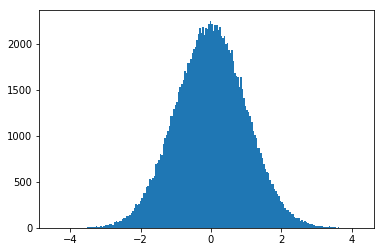

In [20]:
plt.figure()
plt.hist(x.get(),bins=200)
plt.show()

\newpage